In [1]:
library(randomForest)

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.


$`1`
 [1] 709 116 541 245 525 542 204 488 167 728 221 228 186 187 597 197 565  32 375
[20] 241 373 587 201 370 568  76 193  77 410 534 487 766 166 467 284 628 509 225
[39] 553  45 446 742 400 585 343   1 215 220  59 387 682 591 329 174 741 326 142
[58] 669 315 397 647 615 720   5 390 433 378 127 424 712 468 666 393 725  78 317
[77] 737 423

In [15]:
filter_chisq = function(dstrain, ypos="pos", min_count=5,
chi_threshold = 1e-5) {
 nugrams = ncol(dstrain) #number of unigram+1
 chiall = rep(-1, nugrams) 
 yvec = as.numeric(dstrain[,1]==ypos)
 options(warn = -1) #silence the warning
 for(ii in 2:nugrams) {
 tmp1=cbind(yvec, as.numeric(dstrain[,ii]>0))
 tmp1a=table(tmp1[,1], tmp1[,2])

 if(nrow(tmp1a)<2 | ncol(tmp1a)<2) {
 #stop("tmp1a table dimension too small!")
 chiall[ii] = 0
 } else if(sum(tmp1[,2])<=min_count) {
 chiall[ii] = 0
 #cat("feature", ii, "count too low, skip\n")
 } else {
 tmp2=chisq.test(tmp1a, correct=FALSE)
 chiall[ii] = tmp2$statistic
 }
 }
 options(warn = 0) #turn the warnings back on
 o1 = order(chiall, decreasing=TRUE)

 tmpind1 = chiall[o1] > chi_threshold
 if(sum(tmpind1) ==0) {

 return(list(colpos = NULL, colname=NULL, chistat=NULL))
 } else {
 o2=o1[tmpind1]
 retname = names(dstrain)[o2]
 return(list(colpos = o2, colname=retname, chistat=chiall[o2]))
 }
}

In [16]:
rf_carton <- function(dsall, folds, testfold, ypos = "pos",  chi_threshold = 0.1, grid_length = 20,  grid_type = "loglinear", rfntree = 500 ,debuglevel=0){
    
    mytest <-function (confusion){
        precision = (confusion[2,2])/(confusion[1,2] + confusion[2,2])
        recall = (confusion[2,2])/(confusion[2,1] + confusion[2,2])
        f1 = 2 * (precision * recall ) / (precision + recall)
        return(list(precision=precision, recall=recall, f1 = f1))
    }

    ycol=1
    #this is the training dataset
    dstrain_all = dsall[-folds[[testfold]],]
    dstrain_all_y = as.factor(dstrain_all[,ycol] == ypos)
    #testing dataset
    dstest = dsall[folds[[testfold]],]
    dstest_y = as.factor(dstest[,ycol] == ypos)
    if(testfold==1) {
     tunefold=10
    } else {1
     tunefold=testfold-1
    }
    #tuning dataset
    dstune = dsall[folds[[tunefold]],]
    #this is the sub-train dataset
    dstrain = dsall[-c(folds[[tunefold]], folds[[testfold]]),]
    dstrain_y = as.factor(dstrain[,ycol] == ypos)
    dstune_y = as.factor(dstune[,ycol] == ypos)

    features = filter_chisq(dstrain, ypos, chi_threshold = chi_threshold)
    dstrain_new = dstrain[features$colpos]
    dstune_new = dstune[features$colpos]
    ncol = dim(dstrain_new)[2]

    m_min = 2
    m_max = ncol
    grids = NULL
    if(grid_type == "loglinear"){
        grids = unique(round(exp(seq(log(m_min), log(m_max),length=grid_length))))
    }
    else if(grid_type == 'equal'){
        grids = unique(round(seq(m_min, m_max, length=grid_length )))
    }
    
    f1_all = c()
    best_mtry = 2
    best_f1 = -1
    best_test_result = NULL
    for(mtry in grids){
        result = randomForest(x = dstrain_new, y = dstrain_y, xtest=dstune_new,ytest= dstune_y, ntree = rfntree ,mtry = mtry)
        test_result = mytest(result$test$confusion) 
        if(test_result$f1  > best_f1){
            best_f1 = test_result$f1
            best_mtry = mtry
            best_test_result = test_result
        }
        f1_all = c(f1_all, test_result$f1)
        return(result)
    }
    new_features = filter_chisq(dstrain_all, ypos, chi_threshold = chi_threshold)
    dstrain_all = dstrain_all[new_features$colpos]
    dstest = dstest[new_features$colpos]
    final_rf_result = randomForest(x = dstrain_all, y = dstrain_all_y, xtest=dstest,ytest= dstest_y, mtry = best_mtry)
    result = list(mgrids= grids, f1_all=f1_all, best_m=best_mtry, test= mytest(final_rf_result$test$confusion), fselect=new_features)
    return(result)
}

set.seed(5556)
rftest=rf_carton(ds1, cvfold, testfold=7,debuglevel=0)


    




ERROR: Error in rf_carton(ds1, cvfold, testfold = 7, debuglevel = 0): object 'ds1' not found


In [88]:
z = rftest$test$confusion
rftest$test$confusion
z[1]
z[2]
z[3]
z[4]
z[5]
z[6]

,FALSE,TRUE,class.error
FALSE,60,0,0.0000000
TRUE,14,3,0.8235294


[1] 60

[1] 14

[1] 0

[1] 3

[1] 0

[1] 0.8235294

In [68]:
length(rftest$fselect$colpos)

[1] 346

In [31]:
dim(dstrain_all)
dim(dstrain_y_all)
dim(dstest)

[1] 696 347

NULL

[1]   78 4129

In [ ]:
fin_result = randomForest(x = dstrain_all, y = dstrain_y, xtest=dstune_new,ytest= dstune_y, mtry = mtry)

In [114]:
new_features = filter_chisq(dsall, chi_threshold = chi_threshold)
new_dall = dsall[new_features$colpos]
# new_dall
new_result = randomForest(x = new_dall, y = dsall[,1],  mtry = best_mtry)

In [2]:
install.packages("dplyr")
install.packages("sqldf")
install.packages("ggplot2")
install.packages("reshape2")
install.packages("gridExtra")


Installing package into ‘/home/alvin/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)
also installing the dependencies ‘utf8’, ‘bindr’, ‘cli’, ‘pillar’, ‘purrr’, ‘assertthat’, ‘bindrcpp’, ‘pkgconfig’, ‘rlang’, ‘tibble’, ‘tidyselect’, ‘BH’, ‘plogr’

Installing package into ‘/home/alvin/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)
also installing the dependencies ‘bit’, ‘prettyunits’, ‘bit64’, ‘blob’, ‘gsubfn’, ‘proto’, ‘RSQLite’, ‘DBI’, ‘chron’

Installing package into ‘/home/alvin/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)
also installing the dependencies ‘colorspace’, ‘RColorBrewer’, ‘dichromat’, ‘munsell’, ‘labeling’, ‘viridisLite’, ‘gtable’, ‘MASS’, ‘plyr’, ‘reshape2’, ‘scales’, ‘lazyeval’

Installing package into ‘/home/alvin/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)
Installing package into ‘/home/alvin/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)


In [56]:
install.packages("caret")

Installing package into ‘/home/alvin/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)
also installing the dependencies ‘numDeriv’, ‘SQUAREM’, ‘abind’, ‘mnormt’, ‘foreign’, ‘KernSmooth’, ‘lava’, ‘kernlab’, ‘CVST’, ‘DEoptimR’, ‘magic’, ‘tidyr’, ‘psych’, ‘rpart’, ‘survival’, ‘nnet’, ‘prodlim’, ‘DRR’, ‘robustbase’, ‘sfsmisc’, ‘geometry’, ‘broom’, ‘ipred’, ‘dimRed’, ‘lubridate’, ‘timeDate’, ‘ddalpha’, ‘gower’, ‘RcppRoll’, ‘ModelMetrics’, ‘nlme’, ‘recipes’



In [12]:

library(ggplot2)
library(reshape2)
library(gridExtra)
library(glmnet)
library(randomForest)
library(e1071)

z <- load('data/50kpred.rdata')
df_train_all <- raw1
df_test <- raw_test
df_all <- rbind(df_train_all, df_test)

nrow(df_test)


[1] 15060

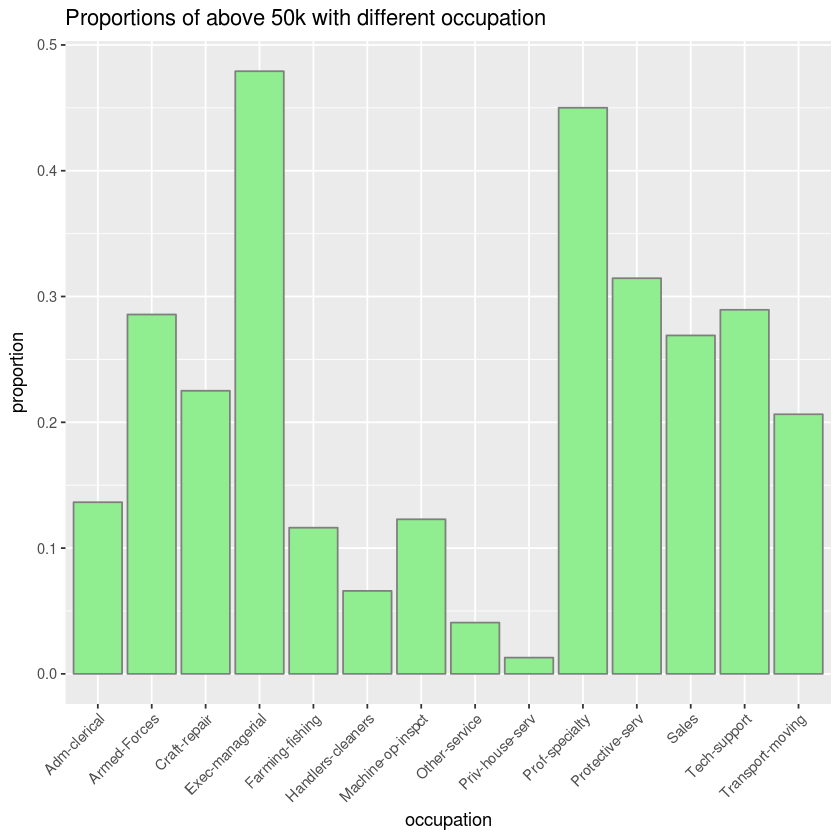

In [22]:
plotPorpotion <- function(df, feature){
    
    occupation_above = data.frame(table(df[df[,"y_income" ] == TRUE,]$occupation))
    occupation_below = data.frame(table(df[df[,"y_income" ] == FALSE,]$occupation))
    occupation_all = data.frame(table(df[df[,"y_income" ] == FALSE,]$occupation))
    occupation = merge(x = occupation_above, y = occupation_below, by = "Var1")
    occu_names = c('occupation', 'above', 'below')
    colnames(occupation) = occu_names
    occupation$above_proportion = occupation$above/ (occupation$above + occupation$below)
    ggplot(occupation, aes(x=occupation, y=above_proportion, ), xlab="Gender", ylab="Counts") + 
        geom_bar(stat="identity", fill="lightgreen", color="grey50") +
        theme(axis.text.x = element_text(angle = 45, hjust = 1))+
        ggtitle('Proportions of above 50k with different occupation')+ 
          xlab("occupation") +
          ylab("proportion") 
}
plotPorpotion(df_all, 'occupation')

In [28]:
table(df_all$y_income)
sum(df_all$y_income == TRUE) / nrow(df_all)


FALSE  TRUE 
34014 11208 

[1] 0.247844

In [29]:
table(df_all$occupation)


     Adm-clerical      Armed-Forces      Craft-repair   Exec-managerial 
             5540                14              6020              5984 
  Farming-fishing Handlers-cleaners Machine-op-inspct     Other-service 
             1480              2046              2970              4808 
  Priv-house-serv    Prof-specialty   Protective-serv             Sales 
              232              6008               976              5408 
     Tech-support  Transport-moving 
             1420              2316 

In [2]:
standarize <- function(x_train, x_test){
    x_train_mean = t(apply(x_train, 2, function(x) mean(x, na.rm=TRUE)))                  
    x_train_sd = apply(x_train, 2, function(x) sd(x, na.rm=TRUE))
    x_train_new = sweep(x_train, 2, x_train_mean)
    x_train_new = sweep(x_train_new, MARGIN=2, x_train_sd,`/`)
    x_test_new = sweep(x_test, 2, x_train_mean)
    x_test_new = sweep(x_test_new, MARGIN=2, x_train_sd,`/`)                   
    return(list(x_train = x_train_new, x_test = x_test_new))
}
getFeatureClasses <- function(df, dum_features){
    result = list()
    i <- 1
    for(feat in dum_features){
        cl =  as.vector(data.frame(table(df[,feat]))[table(df[,feat]) > 50,1])
        result[[feat]] = cl
        i <- i + 1
    }
    return(result)
}
                    
cbind.fill<-function(...){
  nm <- list(...) 
  nm<-lapply(nm, as.matrix)
  n <- max(sapply(nm, nrow)) 
  as.data.frame(do.call(cbind, lapply(nm, function (x) 
    rbind(x, matrix(, n-nrow(x), ncol(x))))))
}

In [233]:
nrow(df_train_all_dummy)
nrow(df_train_all_cont)

[1] 30162

[1] 15060

In [3]:
onehotencoding <- function(dum_features, dum_classes, df){
    df = df[,dum_features]
    for(feature in dum_features){
        classes = dum_classes[feature]
        for(c in classes){
            dummy <- as.numeric(df[feature] == c)
            dum_class_name = paste(feature, c, sep="_")
            df[dum_class_name] = dummy
        }
    }
    return(df[ , !(names(df) %in% dum_features)])
}


dum_features = c("workclass", "marital_status", "occupation","relationship", "race", "sex", "native_country")
dum_classes = getFeatureClasses(df_all, dum_features)
df_train_all_dummy = onehotencoding(dum_features, dum_classes, df_train_all)
df_test_dummy = onehotencoding(dum_features, dum_classes, df_test)

continuous_features = c("age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week")
df_train_all_cont = df_train_all[,continuous_features]
df_test_cont = df_test[,continuous_features]
df_train_all_cont_std = standarize(df_train_all_cont, df_test_cont)$x_train
df_test_cont_std = standarize(df_train_all_cont, df_test_cont)$x_test
df_train_all_x = cbind.fill(df_train_all_cont_std,df_train_all_dummy)
df_train_all_y = df_train_all$y_income
df_tune_x <- df_train_all_x[folds == 10,]
df_tune_y <- df_train_all[folds == 10,]$y_income
df_train_x <- df_train_all_x[folds!= 10, ]
df_train_y <- df_train_all[folds != 10,]$y_income
df_test_x = cbind.fill(df_test_cont_std,df_test_dummy)
df_test_y = df_test$y_income

In [4]:
dum_classes

$workclass
[1] "Federal-gov"      "Local-gov"        "Private"          "Self-emp-inc"    
[5] "Self-emp-not-inc" "State-gov"       

$marital_status
[1] "Divorced"              "Married-civ-spouse"    "Married-spouse-absent"
[4] "Never-married"         "Separated"             "Widowed"              

$occupation
 [1] "Adm-clerical"      "Craft-repair"      "Exec-managerial"  
 [4] "Farming-fishing"   "Handlers-cleaners" "Machine-op-inspct"
 [7] "Other-service"     "Priv-house-serv"   "Prof-specialty"   
[10] "Protective-serv"   "Sales"             "Tech-support"     
[13] "Transport-moving" 

$relationship
[1] "Husband"        "Not-in-family"  "Other-relative" "Own-child"     
[5] "Unmarried"      "Wife"          

$race
[1] "Amer-Indian-Eskimo" "Asian-Pac-Islander" "Black"             
[4] "Other"              "White"             

$sex
[1] "Female" "Male"  

$native_country
 [1] "Canada"             "China"              "Columbia"          
 [4] "Cuba"               "Dominican-Republic" "El-Salvador"       
 [7] "England"            "Germany"            "Guatemala"         
[10] "Haiti"              "India"              "Iran"              
[13] "Italy"              "Jamaica"            "Japan"             
[16] "Mexico"             "Philippines"        "Poland"            
[19] "Portugal"           "Puerto-Rico"        "South"             
[22] "Taiwan"             "United-States"      "Vietnam"

In [30]:


alpha = c(1, 0.1, 0.001, 0.0001,  0)
err_list = c()
for(a in alpha){
    fit <- glmnet(as.matrix(df_train_x), df_train_y, alpha = a, family="binomial")
    x_predict_result = predict(fit, as.matrix(df_tune_x), s = 0.0001, type = "response") >= 0.5
    err = 1 - sum((df_tune_y == x_predict_result) == TRUE) / length(x_predict_result)
    err_list = c(err_list,err)
}
data.frame(alpha = alpha, error_rate = err_list)

alpha,error_rate
1e+00,0.1771080
1e-01,0.1771080
1e-03,0.1815103
1e-04,0.1815103
0e+00,0.1815103


In [31]:
fit <- glmnet(as.matrix(df_train_all_x), df_train_all_y, alpha = 1, family="binomial")
x_predict_result = predict(fit, as.matrix(df_test_x), s = 0.0001, type = "response") >= 0.5
err = 1-sum((df_test_y == x_predict_result) == TRUE) / length(x_predict_result)
err

[1] 0.1934927

In [33]:

fit <- glmnet(as.matrix(df_train_all_x), df_train_all_y, alpha = 0.1, family="binomial")
x_predict_result = predict(fit, as.matrix(df_test_x), s = 0.0001, type = "response") >= 0.5
err = 1-sum((df_test_y == x_predict_result) == TRUE) / length(x_predict_result)
err

[1] 0.1936919

In [28]:
randomForestTuning <- function(df_train_x, df_train_y, df_tune_x, df_tune_y,  df_train_all_x, df_train_all_y, df_test_x, df_test_y, grid_length = 20,  grid_type = "equal", rfntree = 50 ,debuglevel=0){
    mytest <-function (confusion){
        precision = (confusion[2,2])/(confusion[1,2] + confusion[2,2])
        recall = (confusion[2,2])/(confusion[2,1] + confusion[2,2])
        f1 = 2 * (precision * recall ) / (precision + recall)
        return(list(precision=precision, recall=recall, f1 = f1))
    }

    errtest <- function (test){
        acc = sum (((test$pred >= 0.5) == df_tune_y) == TRUE) / length(df_tune_y)
        return(1 - acc)
    }
    ncol = dim(df_train_x)[2]
    m_min = 2
    m_max = ncol
    grids = NULL
    if(grid_type == "loglinear"){
        grids = unique(round(exp(seq(log(m_min), log(m_max),length=grid_length))))
    }
    else if(grid_type == 'equal'){
        grids = unique(round(seq(m_min, m_max, length=grid_length )))
    }
    
    best_mtry = 7
    best_err = 1000
    err_list = c()
    best_rf = NULL
    mtrys = c(2)
    for(mtry in grids){
        result = randomForest(x = df_train_x, y = df_train_y, xtest=df_tune_x,ytest= df_tune_y, ntree = rfntree ,mtry = mtry)
        test_err = errtest(result$test) 
        err_list = c(err_list, test_err)
        print(test_err)
        if(test_err  < best_err){
            best_err = test_err
            best_mtry = mtry
            best_rf = result
        }else{
            break;
        }
    } 
    return(list(best_mtry = best_mtry, mtrys = mtrys,err_list = err_list, test_err = test_err, best_rf = best_rf))
}


rf = randomForestTuning(df_train_x, df_train_y, df_tune_x, df_tune_y,  df_train_all_x, df_train_all_y, df_test_x, df_test_y)







Warning message in randomForest.default(x = df_train_x, y = df_train_y, xtest = df_tune_x, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

[1] 0.2485608


In [34]:
rf = randomForest(x = df_train_x, y = df_train_y, xtest=df_test_x,ytest= df_test_y, ntree = 100 ,mtry = 11)

Warning message in randomForest.default(x = df_train_x, y = df_train_y, xtest = df_test_x, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

In [35]:
errtest <- function (test){
    acc = sum (((test$pred >= 0.5) == df_test_y) == TRUE) / length(df_test_y)
    return(1 - acc)
}
errtest(rf$test)

[1] 0.1711819

In [77]:
pred = (rf2$test$pred >= 0.5) == df_test_y

In [6]:
acc = sum (((rf2$test$pred >= 0.5) == df_tune_y) == TRUE) / length(df_tune_y)
acc

[1] 0.8347443

In [14]:
svm_model = svm(as.matrix(df_train_x), as.matrix(df_train_y) , type = "C", c)

In [51]:
costs = c(2, 1, 0.1)
err_list = c()

svm_model = svm(as.matrix(df_train_x), as.matrix(df_train_y), type = "C", cost = 10, probability=TRUE)
predict = predict(svm_model, newdata = as.matrix(df_tune_x))
error_rate = 1 - sum((df_tune_y == predict) == TRUE) / length(df_tune_y)
error_rate

[1] 0.1815103

In [52]:
predict = predict(svm_model, newdata = as.matrix(df_test_x),  probability=TRUE)
error_rate = 1 - sum((df_test_y == predict) == TRUE) / length(df_test_y)
error_rate

[1] 0.1890438

In [55]:
head(attr(predict, "prob")[1:10,])

,FALSE,TRUE
1,0.8442286,0.1557714
2,0.8281356,0.1718644
3,0.8790349,0.1209651
4,0.1080169,0.8919831
6,0.8536568,0.1463432
8,0.1145552,0.8854448
